# Develop an initial model and split datasets

In [62]:
# from fastai import *

import pandas as pd
from pathlib import Path
import torch
from fastai.vision.all import *
from fastai.vision.widgets import *
# fastai library simplifies training fast and accurate neural nets using modern best practices
# https://www.mdpi.com/2078-2489/11/2/108/htm

In [29]:
!pip uninstall ipywidgets -y
!pip install ipywidgets


Found existing installation: ipywidgets 7.7.2
Uninstalling ipywidgets-7.7.2:
  Successfully uninstalled ipywidgets-7.7.2
  Obtaining dependency information for ipywidgets from https://files.pythonhosted.org/packages/4a/0e/57ed498fafbc60419a9332d872e929879ceba2d73cb11d284d7112472b3e/ipywidgets-8.1.1-py3-none-any.whl.metadata
  Obtaining dependency information for comm>=0.1.3 from https://files.pythonhosted.org/packages/fe/47/0133ac1b7dc476ed77710715e98077119b3d9bae56b13f6f9055e7da1c53/comm-0.1.4-py3-none-any.whl.metadata
  Using cached comm-0.1.4-py3-none-any.whl.metadata (4.2 kB)
  Obtaining dependency information for widgetsnbextension~=4.0.9 from https://files.pythonhosted.org/packages/29/03/107d96077c4befed191f7ad1a12c7b52a8f9d2778a5836d59f9855c105f6/widgetsnbextension-4.0.9-py3-none-any.whl.metadata
  Obtaining dependency information for jupyterlab-widgets~=3.0.9 from https://files.pythonhosted.org/packages/e8/05/0ebab152288693b5ec7b339aab857362947031143b282853b4c2dd4b5b40/jupyterl

In [32]:
!jupyter nbextension install --py --symlink --sys-prefix widgetsnbextension
!jupyter nbextension enable --py --sys-prefix widgetsnbextension


Installing /opt/homebrew/lib/python3.10/site-packages/widgetsnbextension/static -> jupyter-js-widgets
Symlinking: /opt/homebrew/opt/python@3.10/Frameworks/Python.framework/Versions/3.10/share/jupyter/nbextensions/jupyter-js-widgets -> /opt/homebrew/lib/python3.10/site-packages/widgetsnbextension/static
- Validating: OK

    To initialize this nbextension in the browser every time the notebook (or other app) loads:
    
          jupyter nbextension enable widgetsnbextension --py --sys-prefix
    
Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [63]:
!jupyter nbextension enable --py widgetsnbextension --py --sys-prefix


Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


### Set relative paths

In [64]:
data_path = Path('../../data')
path = Path(data_path/"interim/temp_png")

### Get a list of filenames for all the images in the training data path

In [65]:
# get_jpg_files = FileGetter(extensions='.jpg')

In [66]:
filenames = get_image_files(path)
filenames

(#1998) [Path('../../data/interim/temp_png/call/spectrograms/recording-6714-clip-90536.png'),Path('../../data/interim/temp_png/call/spectrograms/recording-529966-clip-977059.png'),Path('../../data/interim/temp_png/call/spectrograms/recording-100760-clip-422149.png'),Path('../../data/interim/temp_png/call/spectrograms/recording-100226-clip-362208.png'),Path('../../data/interim/temp_png/call/spectrograms/recording-320901-clip-731347.png'),Path('../../data/interim/temp_png/call/spectrograms/recording-248819-clip-952672.png'),Path('../../data/interim/temp_png/call/spectrograms/recording-552380-clip-645239.png'),Path('../../data/interim/temp_png/call/spectrograms/recording-292199-clip-569065.png'),Path('../../data/interim/temp_png/call/spectrograms/recording-217279-clip-755445.png'),Path('../../data/interim/temp_png/call/spectrograms/recording-100144-clip-349271.png')...]

In [67]:
def grandparent_label(item):
    "Label `item` with the name of the folder 2 levels up"
    return Path(item).parent.parent.name

# DataBlock
Framework for creating a dataloaders object. 
- blocks is where we specify the types of features and labels (Image as input, categorical output)
- sampling 20% of the data and using that as the validation set.
- using this framework we can build a __dataloaders__ 


Some of the terminology in PyTorch and fastai can be confusing. They can have similar names which mean very specific things. Here are the definintions

- Dataset: an iterable over tuples containing images with their corresponding category.
- Datasets: a fastai class which joins together a training dataset and a validation dataset into one object.
- DataLoader: a PyTorch iterable returning a batch of datasets.
- DataLoaders: a fastai iterable which splits dataloaders into training and validation datasets.
- batch: The sample of the dataset loaded in parallel and passed to the model during one training loop.


In [68]:
birds = DataBlock(
    blocks = (ImageBlock, CategoryBlock), 
    get_items = get_image_files,
    splitter = RandomSplitter(valid_pct=0.2),
    get_y = grandparent_label)

In [69]:
birds.summary(path)

Setting-up type transforms pipelines
Found 1998 items
2 datasets of sizes 1599,399
Setting up Pipeline: PILBase.create
Setting up Pipeline: grandparent_label -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      ../../data/interim/temp_png/call/spectrograms/recording-103783-clip-274566.png
    applying PILBase.create gives
      PILImage mode=RGB size=224x224
  Pipeline: grandparent_label -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      ../../data/interim/temp_png/call/spectrograms/recording-103783-clip-274566.png
    applying grandparent_label gives
      call
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(0)

Final sample: (PILImage mode=RGB size=224x224, TensorCategory(0))


Found 1998 items
2 datasets of sizes 1599,399
Setting up Pipeline: PILBase.create
Setting up Pipeline: grandparent_label -> Categorize -- 

This summary shows the two datasets used for training - the larger training set and the smaller validation set. 

In [70]:
dataloaders = birds.dataloaders(path)

In [71]:
x,y = dataloaders.one_batch()
x.shape, y.shape

(torch.Size([64, 3, 224, 224]), torch.Size([64]))

- Here we can see the batch size is 64, and contains 3 channel images of 224*224 px 
- The length of the labels is just a tensor containg 64 elements. 
The 3 channel means we're loading these images into the tensor as RGB images instead of greyscale images, which is redundant. This should be changed.

# here are 9 items from a typical batch. 
Note this is before any attempt to process the data to include high quality samples, or to curate a no_call dataset which doesn't contain calls of the olive sided flycatcher. This no_call dataset is made from clips tagged as other species than the olive sided flycatcher - but there could still be OSFL calls in the background. 

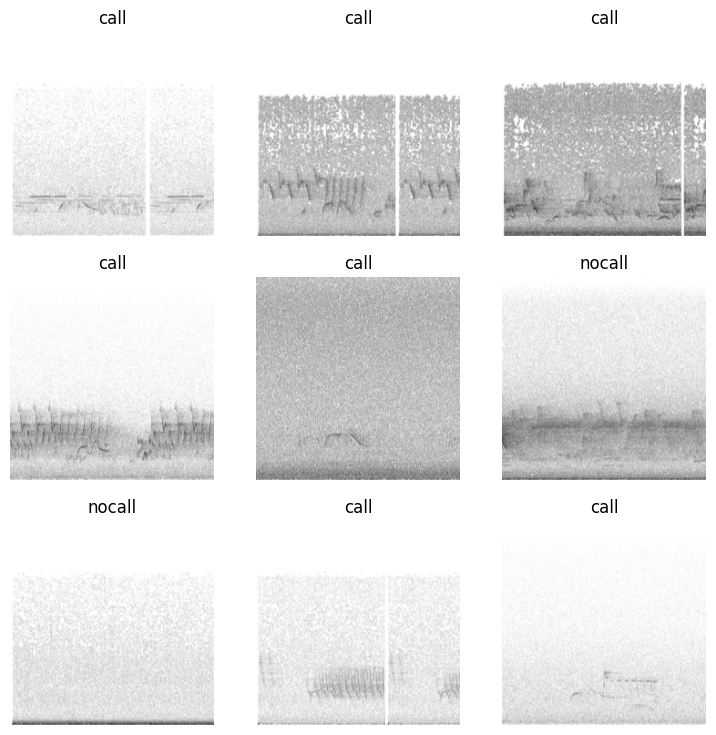

In [ ]:
dataloaders.train.show_batch(unique=False)

# Train a model using transfer learning
The model being retranined is a resnet 18 model trained on the imagenet database. 

In [73]:
learn = vision_learner(dataloaders, resnet18, metrics = error_rate)

In [74]:
%time learn.fine_tune(2)

epoch,train_loss,valid_loss,error_rate,time
0,1.098857,1.449835,0.433584,00:24


epoch,train_loss,valid_loss,error_rate,time
0,0.799071,0.781918,0.288221,00:37
1,0.568858,0.518153,0.218045,00:40


CPU times: user 19.6 s, sys: 4.81 s, total: 24.4 s
Wall time: 1min 43s


During initial run there was an error: 
TypeError: Exception occured in `ProgressCallback` when calling event `after_batch`:
	unsupported format string passed to TensorBase.__format__
    
- Fix: Updated the virtual environment - this was an issue with a change in the PyTorch package not allowing subclasses in Tensor.format

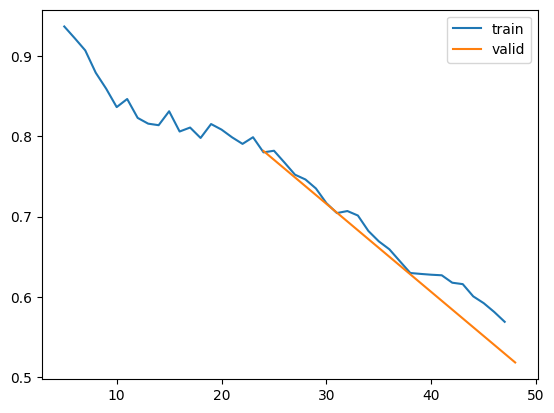

In [75]:
learn.recorder.plot_loss()

Graph interpretation
It's too early to make conclusions from the error rate values at this point due to class inbalance.
- but the curves are showing that the model is training. 
- The blue curve shows the model's performance on items in the training set; the model is learning the specific items in the training set.

- The orange curve shows the model's performance on unseen samples. This is how well the model will generalise to unseen data.  To train a good model, we want to see the  orange curve reducing as the model trains.



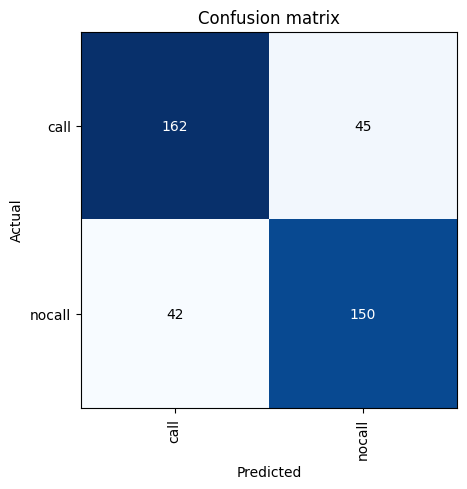

In [76]:
interpreter = ClassificationInterpretation.from_learner(learn)
interpreter.plot_confusion_matrix()

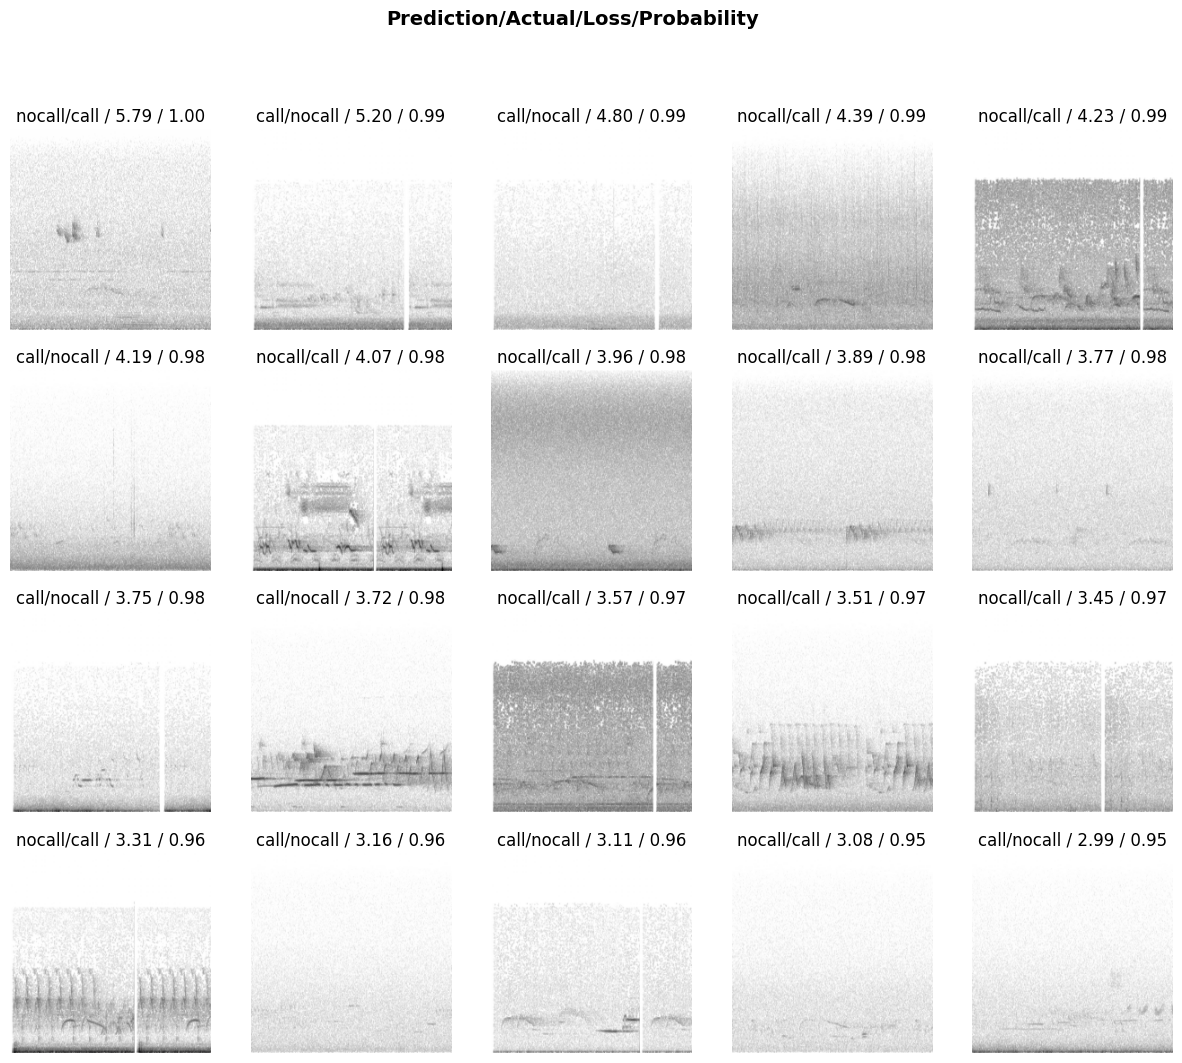

In [ ]:
interpreter.plot_top_losses(20)

In [78]:
ImagesCleaner??

In [79]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [80]:
cleaner

In [81]:
!pip list

Package              Version
-------------------- -----------
aiohttp              3.8.3
aiosignal            1.3.1
anyio                3.6.2
appdirs              1.4.4
appnope              0.1.3
argon2-cffi          21.3.0
argon2-cffi-bindings 21.2.0
arrow                1.2.3
aru-metadata-parser  0.1.0
asttokens            2.2.1
async-timeout        4.0.2
attrs                22.2.0
audioread            3.0.0
Babel                2.11.0
backcall             0.2.0
beautifulsoup4       4.11.2
binaryornot          0.4.4
black                23.9.1
bleach               6.0.0
blis                 0.7.9
brewer2mpl           1.4.1
catalogue            2.0.8
certifi              2022.12.7
cffi                 1.15.1
chardet              5.2.0
charset-normalizer   2.1.1
click                8.1.3
colorednoise         2.1.0
colour               0.1.5
comm                 0.1.4
confection           0.0.4
contextlib2          21.6.0
contourpy            1.0.7
cookiecutter         2.3.0
cycler  

In [24]:
ImageClassifierCleaner??

ValueError: Could not save to JPEG for display

For some reasonm the images are getting converted to RGBA format, a format which isn't supported by jpeg.

In [ ]:
im = Image.open(filenames[0])

In [ ]:
im.mode

In [ ]:
im = im.convert('L')

In [ ]:
_

In [ ]:
def greyscale_to_rgba(im: PIL.Image.Image) -> PIL.Image.Image:
    return im.convert("RGBA")

# Make sure that the images are 3 channel images

In [72]:
filenames[0]

Path('../../data/interim/temp_png/call/spectrograms/recording-6714-clip-90536.png')

ValueError: Could not save to JPEG for display

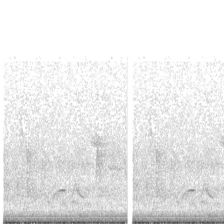

In [23]:
image = Image.open(filenames[0])
image = image.convert("RGBA")
image

In [77]:
image.mode

'RGBA'

ValueError: Could not save to JPEG for display

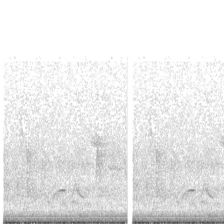

In [78]:
image

In [25]:
ImagesCleaner??

In [24]:
ImageClassifierCleaner??

In [22]:
dataloaders = birds.new(_tfms=[greyscale_to_rgb, ToTensor()])

TypeError: DataBlock.new() got an unexpected keyword argument '_tfms'

In [ ]:
learn = Learner(dataloaders, resnet18, loss_func=error_rate)

In [ ]:
learn.fit_one_cycle(4)

In [ ]:
cleaner = ImageClassifierCleaner(learn, max_n=2)

In [ ]:
ToTensor

In [ ]:
birds = DataBlock(
    blocks = (ImageBlock, CategoryBlock), 
    get_items = get_image_files,
    splitter = RandomSplitter(valid_pct=0.2),
    get_y = parent_label,
    item_tfms = [rgba_to_rgb, ToTensor])  # Add the conversion transform here

In [ ]:
dataloaders = birds.dataloaders(path)

In [ ]:
rgba_to_rgb(Image.open(filenames[0])).

In [27]:
cleaner = ImageClassifierCleaner(learn, max_n=2)

NameError: name '_open_thumb' is not defined